In [1]:
import pandas as pd
import numpy as np
from scipy.stats import beta
import seaborn as sns
import matplotlib.pyplot as plt
import gc
from tqdm import tqdm


path = './data/'
output = './output/'
figs = './figs/'


In [2]:
df = pd.read_csv(path+'RegularSeasonDetailedResults.csv')
df2 = pd.read_csv(path+'Prelim2019_RegularSeasonDetailedResults.csv')
df = pd.concat([df,df2],axis=0)
del df2
gc.collect()

7

In [3]:
print(len(df))
# for some reason df has duplicate rows
df = df.drop_duplicates()
print(len(df))
teams = pd.read_csv(path+'Teams.csv')

169407
87366


### This is an experiment on bayesian updating and graphing. I'll probably end up making a medium post about it.
### Ultimately I want it to be the basis for a college basketball model and compare it to my Elo model

First goal:

College basketball can be thought of as a combination of three stats. Offensive efficiency, defensive efficiency, and pace. Let's say Kentucky is playing Louisville in December. The Vegas line looks off to me, and I want to predict the final score.

If I know both team's pace stats, I can predict how many possessions will happen in a game. In further work I will explore how scoring differential impacts pace and efficiency.

Let's say I know that both teams will have 70 possessions. If I also know how efficient the teams will be on those possessions, I can predict the final score. If Kentucky scores 1.1 points per possession, and Louisville scores 1.05, the final score will be somewhere around 77-74.

To start, I'm going to assume every team is average in terms of shooting efficiency, pace, etc. Then, game by game, I'll use bayesian updating to adjust those priors and hopefully by the end of the season we can be relatively certain how efficient teams are.


In [4]:
df.head()

,Season,DayNum,WTeamID,WScore,LTeamID,LScore,WLoc,NumOT,WFGM,WFGA,...,LFGA3,LFTM,LFTA,LOR,LDR,LAst,LTO,LStl,LBlk,LPF
0,2003,10,1104,68,1328,62,N,0,27,58,...,10,16,22,10,22,8,18,9,2,20
1,2003,10,1272,70,1393,63,N,0,26,62,...,24,9,20,20,25,7,12,8,6,16
2,2003,11,1266,73,1437,61,N,0,24,58,...,26,14,23,31,22,9,12,2,5,23
3,2003,11,1296,56,1457,50,N,0,18,38,...,22,8,15,17,20,9,19,4,3,23
4,2003,11,1400,77,1208,71,N,0,30,61,...,16,17,27,21,15,12,10,7,1,14


In [5]:
def team_by_team(df):
    # preprocessing 
    df = df.loc[df.Season>=2009]
    print(len(df))
    new_cols = []
    for column in list(df):
        if column == 'WLoc':
            new_cols.append('WLoc')
        else:
            column = column.replace("W","")
            column = column.replace("L","Opp")
            new_cols.append(column)

    print(new_cols)
    df.columns=new_cols
    opp_df = df.copy()
    opp_cols = list(opp_df)

    static_cols = ['Season','DayNum','WLoc','NumOT']
    new_oc = []

    for col in opp_cols:
        if col in static_cols:
            new_oc.append(col)
        elif "Opp" in col:
            new_oc.append(col.replace("Opp",""))
        else:
            new_oc.append('Opp'+col)

    print(new_oc)

    opp_df.columns=new_oc
    # adjust location
    reverse = {
        'H':'A',
        'A':'H',
        'N':'N'
    }

    opp_df['WLoc'] = opp_df['WLoc'].replace(reverse)
    opp_df = opp_df[new_cols]
    df = pd.concat([opp_df,df],axis=0)

    df = df.rename(columns={'WLoc':'Loc'})
    return df



In [6]:
df = team_by_team(df)


58541
['Season', 'DayNum', 'TeamID', 'Score', 'OppTeamID', 'OppScore', 'WLoc', 'NumOT', 'FGM', 'FGA', 'FGM3', 'FGA3', 'FTM', 'FTA', 'OR', 'DR', 'Ast', 'TO', 'Stl', 'Blk', 'PF', 'OppFGM', 'OppFGA', 'OppFGM3', 'OppFGA3', 'OppFTM', 'OppFTA', 'OppOR', 'OppDR', 'OppAst', 'OppTO', 'OppStl', 'OppBlk', 'OppPF']
['Season', 'DayNum', 'OppTeamID', 'OppScore', 'TeamID', 'Score', 'WLoc', 'NumOT', 'OppFGM', 'OppFGA', 'OppFGM3', 'OppFGA3', 'OppFTM', 'OppFTA', 'OppOR', 'OppDR', 'OppAst', 'OppTO', 'OppStl', 'OppBlk', 'OppPF', 'FGM', 'FGA', 'FGM3', 'FGA3', 'FTM', 'FTA', 'OR', 'DR', 'Ast', 'TO', 'Stl', 'Blk', 'PF']


In [7]:
df = df.sort_values(by=['Season','DayNum','TeamID'])
# df.groupby(['Season','TeamID'])['Score'].cumcount()

In [8]:
# let's start with a binomial 3 point distribution

# total 3 pointers made 
FGM3 = df.FGM3.sum()
FGA3 = df.FGA3.sum()

base_rate = np.round(FGM3/FGA3, 5)
# team by team average
#34.3

print(FGM3)
print(FGA3)
print(base_rate)


780597
2263669
0.34484


In [9]:
# Method 1: let's see per game error if we predict 34.51% every game
df['3Pt%'] = np.round(df['FGM3']/df['FGA3'],4)
df['Proj1'] = 0.3451
df['Error1'] = np.sqrt(np.square(df['3Pt%']-df['Proj1']))

print(df['Error1'].mean())


0.09274460121965801


In [10]:
# X games in, predict Total - X games
print(len(df))
df = df.sort_values(by=['Season','DayNum'])
df['SoFar_3M'] = df.groupby(['Season','TeamID'])['FGM3'].cumsum()
df['SoFar_3A'] = df.groupby(['Season','TeamID'])['FGA3'].cumsum()

print(len(df))

# get reverse
df = df.sort_values(by=['Season','DayNum'], ascending=False)
df['ToGo_3M'] = df.groupby(['Season','TeamID'])['FGM3'].cumsum()
df['ToGo_3A'] = df.groupby(['Season','TeamID'])['FGA3'].cumsum()
df = df.sort_values(by=['Season','DayNum'])


117082
117082


In [11]:
df['SoFar3Pt%'] = df['SoFar_3M']/df['SoFar_3A']

df['ToGo3Pt%'] = df['ToGo_3M']/df['ToGo_3A']

df['GameNumber'] = df.groupby(['Season','TeamID'])['Score'].cumcount()

df['GameNumber'] += 1

df.head(10)

,Season,DayNum,TeamID,Score,OppTeamID,OppScore,Loc,NumOT,FGM,FGA,...,3Pt%,Proj1,Error1,SoFar_3M,SoFar_3A,ToGo_3M,ToGo_3A,SoFar3Pt%,ToGo3Pt%,GameNumber
28825,2009,7,1181,80,1342,49,H,0,30,63,...,0.2727,0.3451,0.0724,3,11,246,705,0.272727,0.348936,1
28826,2009,7,1204,65,1222,63,N,0,24,62,...,0.3571,0.3451,0.0120,5,14,204,598,0.357143,0.341137,1
28826,2009,7,1222,63,1204,65,N,0,20,57,...,0.3500,0.3451,0.0049,7,20,187,571,0.350000,0.327496,1
28825,2009,7,1342,49,1181,80,A,0,16,53,...,0.1765,0.3451,0.1686,3,17,165,525,0.176471,0.314286,1
28827,2009,8,1181,97,1204,54,H,0,32,66,...,0.4211,0.3451,0.0760,11,30,243,694,0.366667,0.350144,2
28827,2009,8,1204,54,1181,97,A,0,18,64,...,0.2632,0.3451,0.0819,10,33,199,584,0.303030,0.340753,2
28828,2009,8,1222,76,1342,57,N,0,30,56,...,0.4000,0.3451,0.0549,13,35,180,551,0.371429,0.326679,2
28829,2009,8,1237,60,1318,73,N,0,20,51,...,0.1176,0.3451,0.2275,2,17,137,399,0.117647,0.343358,1
28829,2009,8,1318,73,1237,60,N,0,21,50,...,0.3182,0.3451,0.0269,7,22,165,492,0.318182,0.335366,1
28828,2009,8,1342,57,1222,76,N,0,16,40,...,0.2857,0.3451,0.0594,9,38,162,508,0.236842,0.318898,2


In [12]:
print(df.loc[(df['Season']==2010)&(df['TeamID']==1107)].FGA3.sum())
# cumulative sum includes current game, so subract that
df['ToGo_3M'] = df['ToGo_3M']-df['FGM3']
df['ToGo_3A'] = df['ToGo_3A']-df['FGA3']
df.head()

585


,Season,DayNum,TeamID,Score,OppTeamID,OppScore,Loc,NumOT,FGM,FGA,...,3Pt%,Proj1,Error1,SoFar_3M,SoFar_3A,ToGo_3M,ToGo_3A,SoFar3Pt%,ToGo3Pt%,GameNumber
28825,2009,7,1181,80,1342,49,H,0,30,63,...,0.2727,0.3451,0.0724,3,11,243,694,0.272727,0.348936,1
28826,2009,7,1204,65,1222,63,N,0,24,62,...,0.3571,0.3451,0.0120,5,14,199,584,0.357143,0.341137,1
28826,2009,7,1222,63,1204,65,N,0,20,57,...,0.3500,0.3451,0.0049,7,20,180,551,0.350000,0.327496,1
28825,2009,7,1342,49,1181,80,A,0,16,53,...,0.1765,0.3451,0.1686,3,17,162,508,0.176471,0.314286,1
28827,2009,8,1181,97,1204,54,H,0,32,66,...,0.4211,0.3451,0.0760,11,30,235,675,0.366667,0.350144,2


In [13]:
df['Error2'] = np.sqrt(np.square(df['SoFar3Pt%']-df['ToGo3Pt%']))


In [14]:
print(df['ToGo_3A'].min())

test = df.loc[df['ToGo_3A'] > 0]
print(test['ToGo_3A'].min())

0
2


0.031517701565159054


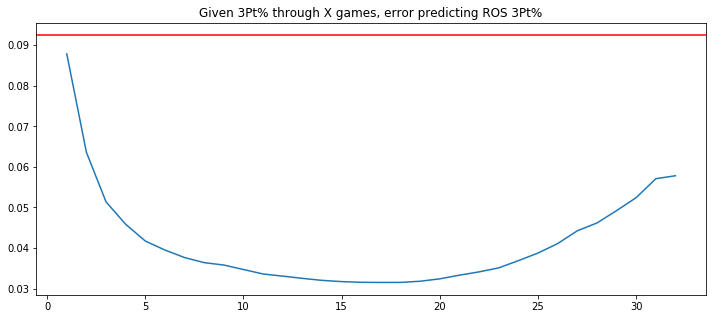

In [15]:

test.groupby(['GameNumber'])['Error2'].count()
# let's do 32 or less games because of sample size
test = test.loc[test['GameNumber']<=32]

x = test.GameNumber.unique()
y = test.groupby(['GameNumber'])['Error2'].mean().values
print(np.min(y))

fig, ax = plt.subplots(1,1,figsize=(12,5))
sns.lineplot(x,y)
ax.axhline(0.09245,color='r')
ax.set_title('Given 3Pt% through X games, error predicting ROS 3Pt%')
plt.savefig(figs+'3PTXGames.png')

In [16]:

df = df.drop(columns=['SoFar_3M','SoFar_3A','SoFar3Pt%','ToGo_3M','ToGo_3A','ToGo3Pt%','Error1','Proj1','Error2'])
print(list(df))


['Season', 'DayNum', 'TeamID', 'Score', 'OppTeamID', 'OppScore', 'Loc', 'NumOT', 'FGM', 'FGA', 'FGM3', 'FGA3', 'FTM', 'FTA', 'OR', 'DR', 'Ast', 'TO', 'Stl', 'Blk', 'PF', 'OppFGM', 'OppFGA', 'OppFGM3', 'OppFGA3', 'OppFTM', 'OppFTA', 'OppOR', 'OppDR', 'OppAst', 'OppTO', 'OppStl', 'OppBlk', 'OppPF', '3Pt%', 'GameNumber']


In [17]:
df['SeaTID'] = df['Season'].astype(str) + df['TeamID'].astype(str)

In [18]:
test = df.copy()

In [19]:
# Simple Moving Average

test = None

windows = list(range(30))
windows = [x + 1 for x in windows]

x = []
y = []

for w in tqdm(windows):
    del test
    gc.collect()
    test = df.copy()

    SMA = test.groupby(['SeaTID']).rolling(w)['3Pt%'].mean().shift(1).reset_index()
    try:
        SMA = SMA.drop(columns=['level_1'])
    except:
        pass
    SMA = SMA.rename(columns={'3Pt%':'Proj'})
    SMA['GameNumber'] = SMA.groupby(['SeaTID'])['Proj'].cumcount()

    SMA['GameNumber'] += 1

    test = pd.merge(test, SMA,  how='left', left_on=['SeaTID','GameNumber'], right_on = ['SeaTID','GameNumber'])
    
    test = test.dropna(subset=['Proj'])
    test['Error'] = np.sqrt(np.square(test['3Pt%']-test['Proj']))
    
    x.append(w)
    y.append(test['Error'].mean())

    
print(x,y)
    

100%|██████████| 30/30 [01:06<00:00,  2.09s/it]

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30] [0.1292787779400586, 0.11221828694300702, 0.10570636393273797, 0.10223978629078095, 0.10014952941754732, 0.09867422903513613, 0.09767682329048241, 0.09692081785983506, 0.09635185489649707, 0.09585406797528173, 0.09552734920592744, 0.09508893004417605, 0.09493322490248265, 0.09459304375564889, 0.09437362689528503, 0.09425970163364089, 0.09407108185710014, 0.09377581648272491, 0.09365257444342213, 0.09352799039811585, 0.09341897747120574, 0.09321721338023958, 0.09283510601612378, 0.09276275586316958, 0.09287398735797728, 0.09276686535828056, 0.0928861772144347, 0.09293895633352155, 0.09271155305749862, 0.0943424262342974]


In [20]:
sma_x = x
sma_y = y


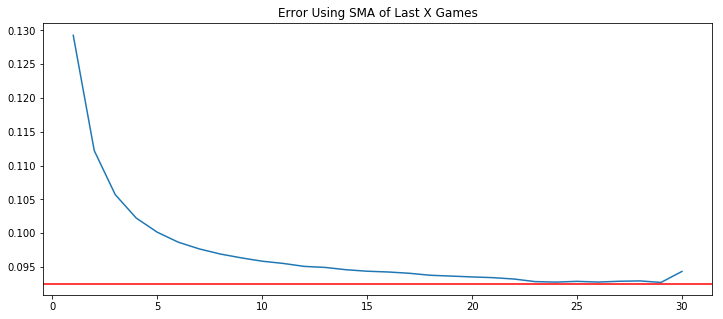

In [21]:

fig, ax = plt.subplots(1,1,figsize=(12,5))
sns.lineplot(sma_x,sma_y)
ax.axhline(0.09245,color='r')
ax.set_title('Error Using SMA of Last X Games')
plt.savefig(figs+'SMAXGames.png')

In [23]:
print(np.min(sma_y))


0.09271155305749862


In [24]:
# Exponential Weighted Average

test = None

x = []
y = []

alphas = np.linspace(0.01,1,31)
print(alphas)

for a in tqdm(alphas):
    del test
    gc.collect()
    test = df.copy()
    test.reset_index(inplace=True,drop=True)

    test = test.assign(
        Proj=test.groupby('SeaTID')['3Pt%'].apply(
            lambda x: x.ewm(alpha=a, adjust=False).mean().shift(1)))
    
    test = test.loc[test['GameNumber']>=29]
    test = test.dropna(subset=['Proj'])
    test['Error'] = np.sqrt(np.square(test['3Pt%']-test['Proj']))
    
    x.append(a)
    y.append(test['Error'].mean())


ema_x = x
ema_y = y
    
    

  0%|          | 0/31 [00:00<?, ?it/s]

[0.01  0.043 0.076 0.109 0.142 0.175 0.208 0.241 0.274 0.307 0.34  0.373
 0.406 0.439 0.472 0.505 0.538 0.571 0.604 0.637 0.67  0.703 0.736 0.769
 0.802 0.835 0.868 0.901 0.934 0.967 1.   ]


100%|██████████| 31/31 [01:22<00:00,  2.48s/it]


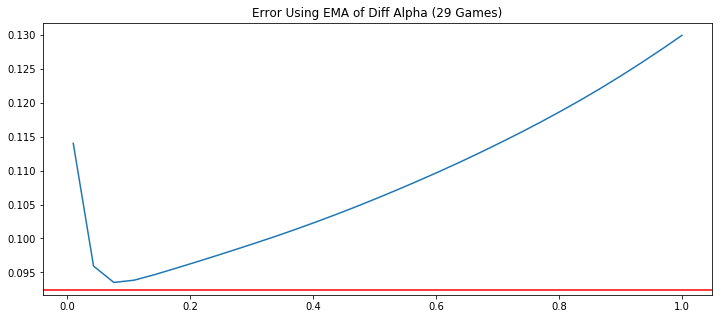

In [25]:
gc.collect()

fig, ax = plt.subplots(1,1,figsize=(12,5))
sns.lineplot(ema_x,ema_y)
ax.axhline(0.09245,color='r')
ax.set_title('Error Using EMA of Diff Alpha (29 Games)')
plt.savefig(figs+'EMAAlpha.png')

In [26]:
print(list(ema_x))
print(list(ema_y))
# .043 - .175

[0.01, 0.043000000000000003, 0.076, 0.109, 0.14200000000000002, 0.17500000000000002, 0.20800000000000002, 0.24100000000000002, 0.274, 0.30700000000000005, 0.34, 0.373, 0.406, 0.43900000000000006, 0.47200000000000003, 0.505, 0.538, 0.5710000000000001, 0.6040000000000001, 0.637, 0.67, 0.7030000000000001, 0.736, 0.769, 0.802, 0.8350000000000001, 0.8680000000000001, 0.901, 0.934, 0.9670000000000001, 1.0]
[0.11404247522235422, 0.09592581774038515, 0.09351139270499974, 0.09384564056934872, 0.09465280322489465, 0.0955542781668956, 0.09647283604371357, 0.0974108286502875, 0.09837040413726883, 0.09934496234593619, 0.10034577356940919, 0.10139054901837254, 0.102473088631049, 0.10359839798499836, 0.1047609848330181, 0.10597243592000714, 0.1072196516188443, 0.10850230852584848, 0.10982761143547665, 0.11118597152476817, 0.11259965609933119, 0.11406168593229518, 0.11556099878161277, 0.11711650427820378, 0.11873708707321799, 0.12041888437397337, 0.1221768429716754, 0.1240120963211571, 0.1259299483291

In [27]:
# do again with better alphas
test = None

x = []
y = []

alphas = np.linspace(.043,.175,25)

for a in tqdm(alphas):
    del test
    gc.collect()
    test = df.copy()
    test.reset_index(inplace=True,drop=True)

    test = test.assign(
        Proj=test.groupby('SeaTID')['3Pt%'].apply(
            lambda x: x.ewm(alpha=a, adjust=False).mean().shift(1)))
    
    test = test.loc[test['GameNumber']>=29]
    test = test.dropna(subset=['Proj'])
    test['Error'] = np.sqrt(np.square(test['3Pt%']-test['Proj']))
    
    x.append(a)
    y.append(test['Error'].mean())


ema_x1 = x
ema_y1 = y
    

100%|██████████| 25/25 [01:05<00:00,  2.59s/it]


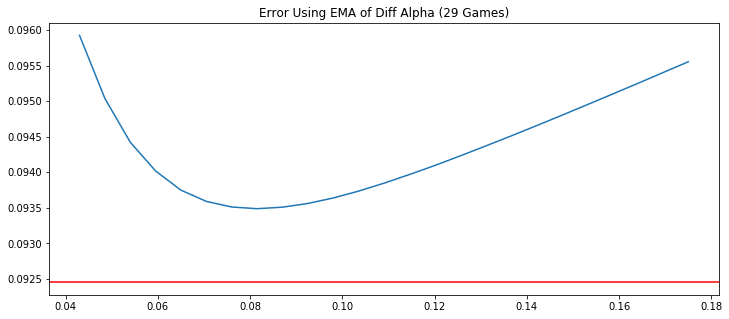

In [28]:
gc.collect()

fig, ax = plt.subplots(1,1,figsize=(12,5))
sns.lineplot(ema_x1,ema_y1)
ax.axhline(0.09245,color='r')
ax.set_title('Error Using EMA of Diff Alpha (29 Games)')
plt.savefig(figs+'EMAAlpha1.png')

In [29]:
np.min(ema_y1)

0.09348742869247553

In [30]:
# what if we use the previous season's 3pt average as a prior?

test = df.copy()
test['PrevYear'] = test['Season'] - 1
test['PrevTID'] = test['PrevY'].astype(str) + test['TeamID'].astype(str)

tgb = test.groupby(['PrevTID'])['3Pt%'].mean().reset_index()

# ny = test[['PrevTID', '3Pt%']]
tgb

KeyError: 'Prev'

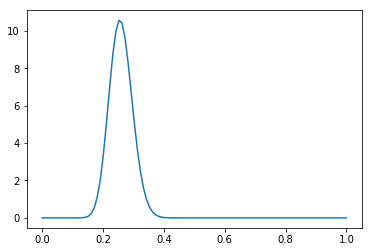

In [26]:
# so, how 'sticky' the prior will be depends on how many samples you use
# if we said the team made 633K/1.8M shots, then the prior wouldn't move
# instead, since we expect variability, we can say the team made 35/100 shots. 
# This is a compromise between not sticky enough and too sticky, and can be adjusted

from scipy.stats import beta
import matplotlib.pyplot as plt
import numpy as np
a =  35
b = 100
x = np.linspace(0, 1.0, 100)
y1 = beta.pdf(x, a, b)
# y2 = beta.pdf(x, 3.25, 3.25)
# y3 = beta.pdf(x, 3, 3)
plt.plot(x, y1, "-")# x, y2, "r--", x, y3, "g--")



['Season',
 'DayNum',
 'TeamID',
 'Score',
 'OppTeamID',
 'OppScore',
 'Loc',
 'NumOT',
 'FGM',
 'FGA',
 'FGM3',
 'FGA3',
 'FTM',
 'FTA',
 'OR',
 'DR',
 'Ast',
 'TO',
 'Stl',
 'Blk',
 'PF',
 'OppFGM',
 'OppFGA',
 'OppFGM3',
 'OppFGA3',
 'OppFTM',
 'OppFTA',
 'OppOR',
 'OppDR',
 'OppAst',
 'OppTO',
 'OppStl',
 'OppBlk',
 'OppPF']

In [71]:
# find worst and best 3pt shooting teams
gb = df.groupby(['Season','TeamID'])['FGM3','FGA3'].sum().reset_index()
gb['3Pt%'] = np.round(gb['FGM3']/gb['FGA3'],4)
gb = gb.sort_values(by='3Pt%')

teams = teams[['TeamID','TeamName']]
gb = pd.merge(gb, teams, how='left', on=['TeamID','TeamID'])
gb['3Pt%'].mean()


0.3436479095074456

In [52]:
# Duke (team code 1181) was bad at 3 point shooting in 2019. 
#Let's see how the distribution evolves over the course of the season

# msu = df.loc[df.TeamID==1277]
# msu = msu.loc[msu.Season==2016]
# len(msu)


68

In [53]:
# msu['FGMiss3'] = msu['FGA3'] - msu['FGM3']
# msu['3Pt%'] = msu['FGM3']/msu['FGA3']

# msu[['FGM3','FGMiss3','3Pt%']].head(15)

,FGM3,FGMiss3,3Pt%
65924,5,8,0.384615
66133,9,12,0.428571
66257,9,17,0.346154
66432,9,11,0.450000
66579,11,10,0.523810
66629,10,13,0.434783
66755,7,15,0.318182
66876,9,14,0.391304
67011,7,19,0.269231
67169,12,10,0.545455


In [54]:
# made = msu.FGM3.values
# missed = msu.FGMiss3.values
# attempts = msu.FGA3.values

# sample_games = 20
# sample_made = made[:sample_games]
# sample_missed = missed[:sample_games]
# sample_attempts = attempts[:sample_games]

# print(np.sum(sample_made)/np.sum(sample_attempts))
# print(sample_made)




0.4326241134751773


0.43
0.41
0.4
0.43
0.45
0.44


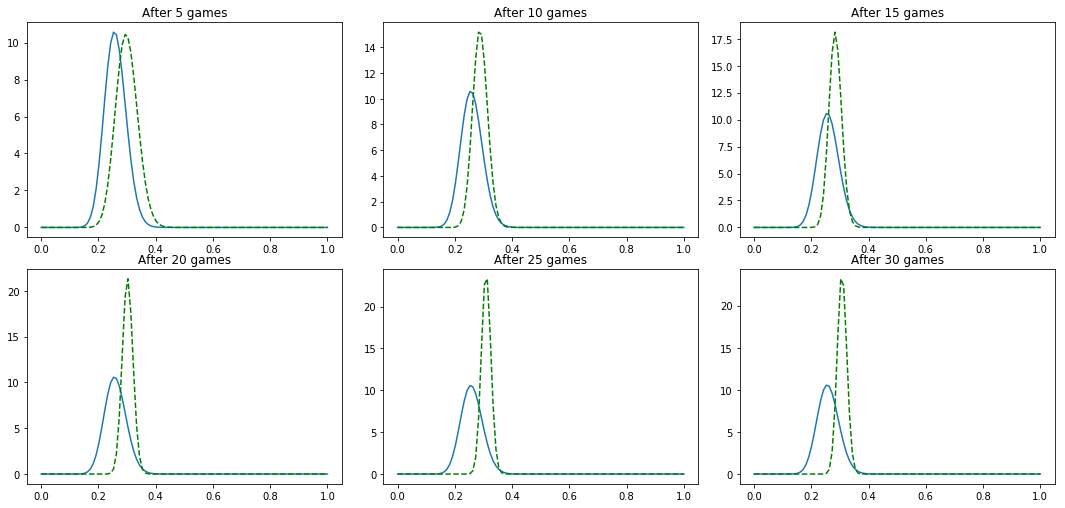

In [60]:

# a =  35
# b = 100
# x = np.linspace(0, 1.0, 100)
# y1 = beta.pdf(x, a, b)
# # y2 = beta.pdf(x, 3.25, 3.25)
# # y3 = beta.pdf(x, 3, 3)
# # plt.plot(x, y1, "-")# x, y2, "r--", x, y3, "g--")

# fig, axs = plt.subplots(2,3, figsize=(15,7))
# fig.tight_layout()

# sample = 0
# grid = {
#     1:[0,0],
#     2:[0,1],
#     3:[0,2],
#     4:[1,0],
#     5:[1,1],
#     6:[1,2]
# }

# for i in range(6):
#     idx = i+1
#     sample += 5
#     low_bound = max(0, sample-25)
#     sample_made = made[low_bound:sample]
#     sample_attempts = attempts[low_bound:sample]
#     pltx, plty = grid[idx]
    
#     c = sample_made.sum()
#     d = sample_attempts.sum()
#     print(np.round(c/d,2))
    
#     y1 = beta.pdf(x, a, b)
#     y2 = beta.pdf(x, c, d)
    
#     axs[pltx,plty].plot(x, y1, "-", x, y2, "g--")
#     axs[pltx,plty].set_title('After {} games'.format(sample))
    
    

In [ ]:
df['3Pt%'] = df['FGM3']/df['FGA3']
df['FG%'] = df['FGM']/df['FGA']


0.3436479095074456
0.02859023293520763
Statistics=0.736, p=0.692


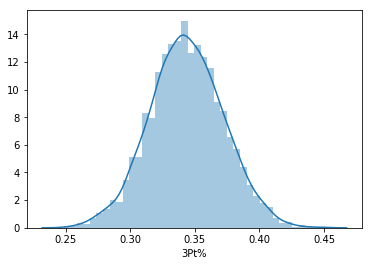

In [69]:
sns.distplot(data)

print(gb['3Pt%'].mean())
print(gb['3Pt%'].std())

from scipy.stats import normaltest
stat, p = normaltest(gb['3Pt%'].values)
print('Statistics=%.3f, p=%.3f' % (stat, p))

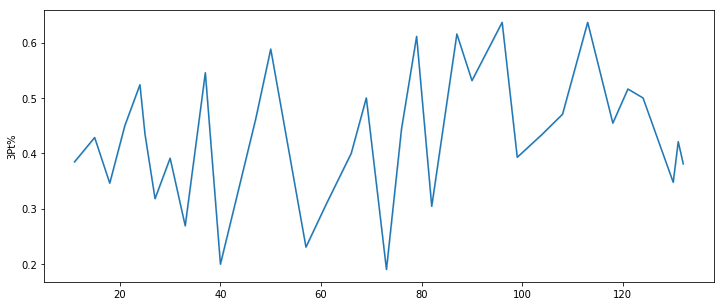

In [63]:
import seaborn as sns

fig, ax = plt.subplots(1,1,figsize=(12, 5))

sns.lineplot(msu['DayNum'].values,msu['3Pt%'])
